# Simple one-way ANOVA 
- 07/28/2022
- HILICpos
- TIC normalized dataset

# load library

In [1]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [2]:
library(dplyr)
library(car)
library(glue)
source("./utilis/utilis.R") # merge_by_rowName


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




## Read data table

In [3]:
exp_label = 'hMinImp_TICnorm_groupFil0.3_HILICpos'

In [4]:
feat_df = read.csv("../../output/preprocessing_59/FC_log2_hMinImp_TICnorm_groupFil0.3_HILICpos_featab.csv", row.names = 1)

In [5]:
head(feat_df)

,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,Naive_percNA,Naive_mean,R5neg_percNA,R5neg_mean,R5pos_percNA,R5pos_mean,gMean_Naive,gMean_R5neg,gMean_R5pos,log2FC_R5negvsNaive,log2FC_R5posvsNaive,log2FC_R5posvsR5neg,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,85.0044,26.00,19.67,28.11,0,2003055,0.96,0.93,106,23,0,70477.0,0,118403.5,0.3333333,33095.5,15.90627,17.05434,14.35138,1.1480751,-1.5548861,-2.7029612,14.72954,16.52419,16.46507,17.00695,17.09726,17.05882,13.45488,15.26659,14.33267,16.25446,16.29809,16.52315
F4,105.0378,29.94,21.80,48.60,491,319536206,1.00,0.97,91,24,0,21717766.0,0,36992809.7,0.0000000,15374962.7,24.35723,25.33316,23.69380,0.9759384,-0.6634247,-1.6393630,24.07682,24.49154,24.50332,25.40913,25.06637,25.52399,23.38120,23.72868,23.97152,21.56720,21.50691,21.33320
F20,130.0874,31.78,29.94,50.70,1924,459680685,1.00,0.92,126,24,0,217572.3,0,225211.0,0.0000000,133405.7,17.32226,17.94356,16.79542,0.6212999,-0.5268469,-1.1481468,16.97935,18.76444,16.22300,18.15003,18.21529,17.46537,16.12229,17.00383,17.26013,25.03785,25.57052,25.29792
F24,151.0971,26.79,23.38,29.16,2390,2167316,0.90,0.90,175,10,0,142990.0,0,298345.7,0.6666667,188441.0,16.77804,18.36806,15.85831,1.5900138,-0.9197309,-2.5097447,16.09626,16.08670,18.15118,18.49526,17.98687,18.62205,15.08670,15.08670,17.40155,NA,NA,NA
F25,117.0379,29.94,26.53,33.89,1003,32831098,1.00,0.95,2850,17,0,2463366.3,0,4966754.3,0.3333333,1370735.0,21.17226,22.43561,17.02232,1.2633433,-4.1499396,-5.4132828,20.56940,21.55389,21.39350,22.55255,22.14998,22.60429,10.56701,20.19821,20.30175,15.96518,15.39953,15.41820
F51,130.8893,26.79,23.38,28.89,1927,61854501,1.00,1.00,7061,22,0,1707885.3,0,1016526.0,0.3333333,990471.5,20.65250,20.14292,19.41125,-0.5095775,-1.2412456,-0.7316681,20.19929,21.12595,20.63225,19.94389,20.37460,20.11027,18.67348,19.83385,19.72643,20.64454,22.73880,22.64871


##### Check the data, make sure it is already log2-transformed

In [6]:
data.df.log2 = feat_df[,grep('Naive\\_[0-9]+|R5[a-z]+\\_[0-9]+',colnames(feat_df))]

## Read metadata

In [7]:
meta_df = read.csv("../../input/sequence_file/clean_meta_df.csv", row.names = 1)

In [8]:
# since the meta_df originally have techincal replicates, which is not unique after technical replicate summaries
# Thus processing metadata a little bit to retain only relevant rows
sub_meta_df <- meta_df[c('tID_dedup','class','biological_samples','cell_number')]
sub_meta_df <- unique(sub_meta_df)

rownames(sub_meta_df) = sub_meta_df$tID_dedup
sub_meta_df = sub_meta_df[colnames(data.df.log2),]
meta_df = sub_meta_df

In [9]:
write.csv(meta_df,"../../input/sequence_file/clean_deduplicated_meta_df.csv", row.names = FALSE)

------

# Summary
- check if the metadata & data matched (It should be as they have been filtered in the last notebook)
- check key metadata

In [10]:
nrow(meta_df) == ncol(data.df.log2)

[1] TRUE

In [11]:
table(meta_df['class'])


Naive R5neg R5pos 
    3     3     3 

### Transpose the table and prepare to merge with meta data

In [12]:
data_df.t = t(data.df.log2) # transpose the table

In [13]:
data_df.t[1:5,1:5]

,F1,F4,F20,F24,F25
Naive_1,14.72954,24.07682,16.97935,16.09626,20.56940
Naive_2,16.52419,24.49154,18.76444,16.08670,21.55389
Naive_3,16.46507,24.50332,16.22300,18.15118,21.39350
R5neg_1,17.00695,25.40913,18.15003,18.49526,22.55255
R5neg_2,17.09726,25.06637,18.21529,17.98687,22.14998


In [14]:
ft_names = colnames(data_df.t);ft_names[1:5]

[1] "F1"  "F4"  "F20" "F24" "F25"

In [15]:
meta_df[1:5,]

,tID_dedup,class,biological_samples,cell_number
,<chr>,<chr>,<chr>,<int>
Naive_1,Naive_1,Naive,Yes,300
Naive_2,Naive_2,Naive,Yes,300
Naive_3,Naive_3,Naive,Yes,300
R5neg_1,R5neg_1,R5neg,Yes,655
R5neg_2,R5neg_2,R5neg,Yes,687


----

------

# Simple one-way ANOVA
- Run all gated populations
- `ft_names`

## Prepare for the table

In [16]:
prep4anova_df = merge_by_rowName(data_df.t, meta_df) # merge data table and metadata

In [17]:
prep4anova_df_filt <- prep4anova_df[,c(
    colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
    c('class') # + critical study design factors
)] # select the columns

In [18]:
prep4anova_df_filt[1:9,c(ncol(prep4anova_df_filt)-1, ncol(prep4anova_df_filt))]

,F14963,class
,<dbl>,<chr>
Naive_1,17.56975,Naive
Naive_2,17.43526,Naive
Naive_3,17.28606,Naive
R5neg_1,17.90785,R5neg
R5neg_2,17.36894,R5neg
R5neg_3,16.75859,R5neg
R5pos_1,17.29842,R5pos
R5pos_2,16.98165,R5pos
R5pos_3,17.35649,R5pos


## Run ANOVA

In [19]:
anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
    return(tryCatch(
        aov(x ~ prep4anova_df[,'class']), # no var.equal as the argument will be disregarded.
        error=function(e) NULL))
})

## Wrap ANOVA result into table

In [20]:
anova_res_list2table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Turn one-way Anova result into table
    temp_row_list <- list()
    for (i in 1:length(anova_res_list)) {
      if(is.null(anova_res_list[[i]])) {
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]),0,1) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      } else {
        anova_res.summary <- summary(anova_res_list[[i]])
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]), anova_res.summary[[1]]['F value'][[1]][1], anova_res.summary[[1]]['Pr(>F)'][[1]][1])
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      }
    }
    anova_res_df = do.call(rbind, temp_row_list)
    anova_res_df$padj <- p.adjust(anova_res_df$pval, method = 'BH') 

    anova_res_df = data.frame(anova_res_df)
    rownames(anova_res_df) = anova_res_df[,1]
    anova_res_df = anova_res_df[,2:ncol(anova_res_df)]
    return(anova_res_df)
}

#### debugging run

In [71]:
# anova_res_df = anova_res_list2table(anova_res_list, "featureID")
# dim(anova_res_df) # the dimension should be the same with original table

[1] 4370    3

## Run tukey test on the `anova_res_list`

In [79]:
anova_res_list2tukeytest_table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Perform tukey test and generate the table from anova result list
    # Also current function only deals with one variable, for 2-way anova or multivariate regression, this function cannot implement
    temp_row_list <- list()
    
    # search for a valid result to get template for set up the NA stuffs
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        
        obj_list = ls(tukey.test) # There will only be one if it is 1-way anova
        obj = obj_list[[1]]
        
        tukey_oriTab = tukey.test[[obj]]
        
        padj_col_names = paste0('Tpadj_',rownames(tukey_oriTab))
        colnames = c(name_of_variable,padj_col_names)
        
        length = dim(tukey_oriTab)[1]
        
        break
        }
    } 
    
    # then go for the real run
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        tukey_oriTab = tukey.test[[obj]]
        temp_row_list[[i]] <- c(names(anova_res_list[i]), 
                                tukey_oriTab[,4] )
        } 
        else 
        {
        temp_row_list[[i]] <- c(names(anova_res_list[i]),
                                rep(NA,length) ) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        
      }
    }
    tukey_res_df = do.call(rbind, temp_row_list)
    colnames(tukey_res_df) = colnames
    
    # handling the fickled things about numeric
    tukey_res_df = data.frame(tukey_res_df)
    rownames = tukey_res_df[,1]
    tukey_res_df = tukey_res_df[,2:ncol(tukey_res_df)]
    tukey_res_df = sapply(tukey_res_df, as.numeric)
    tukey_res_df = data.frame(tukey_res_df)
    rownames(tukey_res_df) = rownames
    
    # correction of Tukey post-hoc stat as well
    Tpadj_cols = colnames(tukey_res_df)[grepl('Tpadj',colnames(tukey_res_df))]
    for (Tpadj_col in Tpadj_cols) {
        tukey_res_df[,gsub('Tpadj','TFDR',Tpadj_col)] <- p.adjust(tukey_res_df[,Tpadj_col], method = 'BH')
    }

    
    # For tukey test, no need to do another round of FDR
    return(tukey_res_df)
}

#### debugging run

In [74]:
# tukey_res_df = anova_res_list2tukeytest_table(anova_res_list,"featureID")

# dim(tukey_res_df)

# aov_tuk_df = merge(anova_res_df,tukey_res_df, by.x = 0, by.y = 0)

# # check if rownames of both table to be merged is the same
# all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)

# dim(aov_tuk_df)
# colnames(aov_tuk_df)

[1] 4370    6

[1] TRUE

[1] 4370   10

[1] "Row.names"         "f_score"           "pval"             
 [4] "padj"              "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive"
 [7] "Tpadj_R5pos.R5neg" "TFDR_R5neg.Naive"  "TFDR_R5pos.Naive" 
[10] "TFDR_R5pos.R5neg"

# Wrapper function

In [80]:
oneway_anova_tukey_analysis <- function(data_df = data_df.t,
                                     meta_df = meta_df,
                                     name_of_class = 'class',
                                     name_of_variable = 'featureID') {
    # always observations as rows, subjects as columns
    # Here only suports 1-way anova which has only one variable
    
    prep4anova_df = merge_by_rowName(data_df, meta_df) # merge data table and metadata
    ft_names = colnames(data_df)
    prep4anova_df_filt <- prep4anova_df[,c(
        colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
        name_of_class)] # select the columns
    
    anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
                        return(tryCatch(
                            aov(x ~ prep4anova_df[,name_of_class]), # no var.equal as the argument will be disregarded.
                            error=function(e) NULL))
                        })
    anova_res_df = anova_res_list2table(anova_res_list, name_of_variable)
    tukey_res_df = anova_res_list2tukeytest_table(anova_res_list, name_of_variable)
    
    # check if rownames of both table to be merged is the same
    msg_check_rowName = all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)
    print(glue('Row name of ANOVA & tukeyTest table is the same? :{msg_check_rowName}'))                           
    
    aov_tuk_df = merge_by_rowName(anova_res_df,tukey_res_df)

    return(aov_tuk_df) # debug: list(anova_res_df,tukey_res_df)
}

In [81]:
aov_tuk_df <- oneway_anova_tukey_analysis(data_df = data_df.t,
                            meta_df = meta_df,
                            name_of_class = 'class',
                            name_of_variable = 'featureID')


Row name of ANOVA & tukeyTest table is the same? :TRUE


In [82]:
head(aov_tuk_df)

,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,TFDR_R5neg.Naive,TFDR_R5pos.Naive,TFDR_R5pos.R5neg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,8.8937320,1.604757e-02,0.0477060464,2.525009e-01,0.11346999,1.340772e-02,0.569658669,0.4245410,0.043642705
F100,0.6509183,5.548268e-01,0.6244123004,9.883995e-01,0.65587558,5.741049e-01,1.000000000,0.9640687,0.727410344
F10000,164.8421502,5.710323e-06,0.0005958801,2.179699e-05,0.03849116,5.862164e-06,0.002442381,0.2762009,0.000826376
F10004,7.4844840,2.342732e-02,0.0612671337,5.185935e-01,0.08764415,2.156493e-02,0.849102118,0.3837725,0.060487001
F10006,11.5954627,8.683807e-03,0.0315446686,8.145709e-01,0.02037338,1.032288e-02,1.000000000,0.2176814,0.036409179
F10007,0.7671954,5.050208e-01,0.5786421349,6.394432e-01,0.97032238,5.107099e-01,0.938019256,1.0000000,0.671420627


In [27]:
colnames(aov_tuk_df)

[1] "f_score"           "pval"              "padj"             
[4] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"

In [83]:
dim(aov_tuk_df)

[1] 4370    9

----

In [84]:
histogram_p <- function(stat_df,p_label, title_label) {
    par(mar=c(10,5,4,1))
    par(mfrow=c(2,2))
    pval_col_list = colnames(stat_df)[grepl(p_label, colnames(stat_df), fixed=TRUE)]
    print(pval_col_list)
    for (pval_col in pval_col_list) {
        hist(stat_df[,pval_col],
             col = 'skyblue3', 
             breaks = 20, 
             xlab=pval_col, 
             main=paste0(title_label,'\n',gsub(p_label,'',pval_col)))
    }
}

[1] "padj"              "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive"
[4] "Tpadj_R5pos.R5neg"


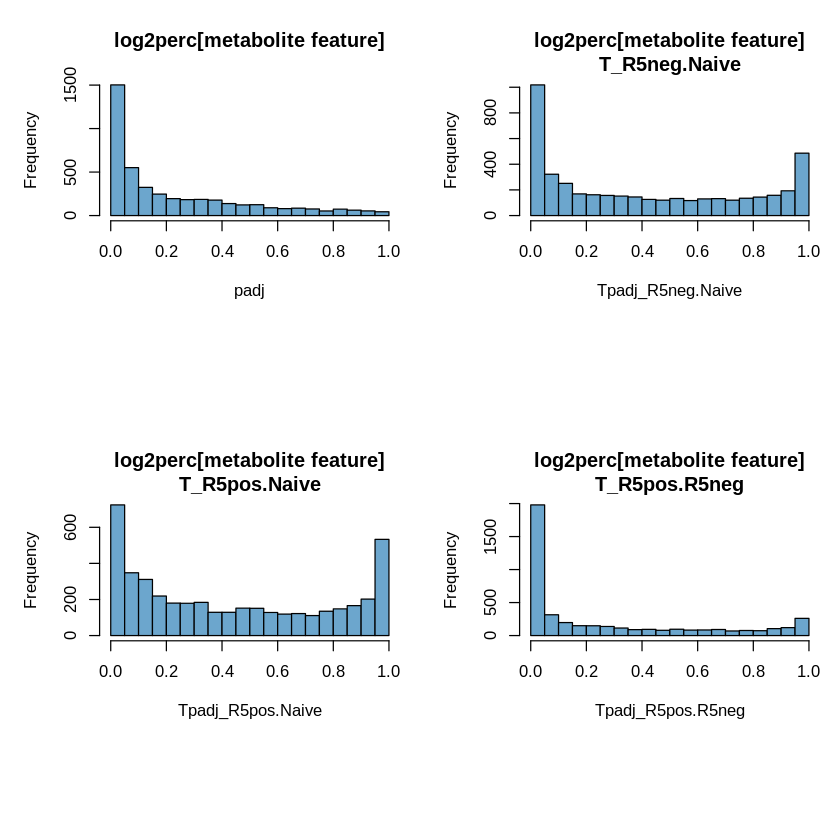

In [85]:
histogram_p(aov_tuk_df,'padj','\nlog2perc[metabolite feature]')

[1] "TFDR_R5neg.Naive" "TFDR_R5pos.Naive" "TFDR_R5pos.R5neg"


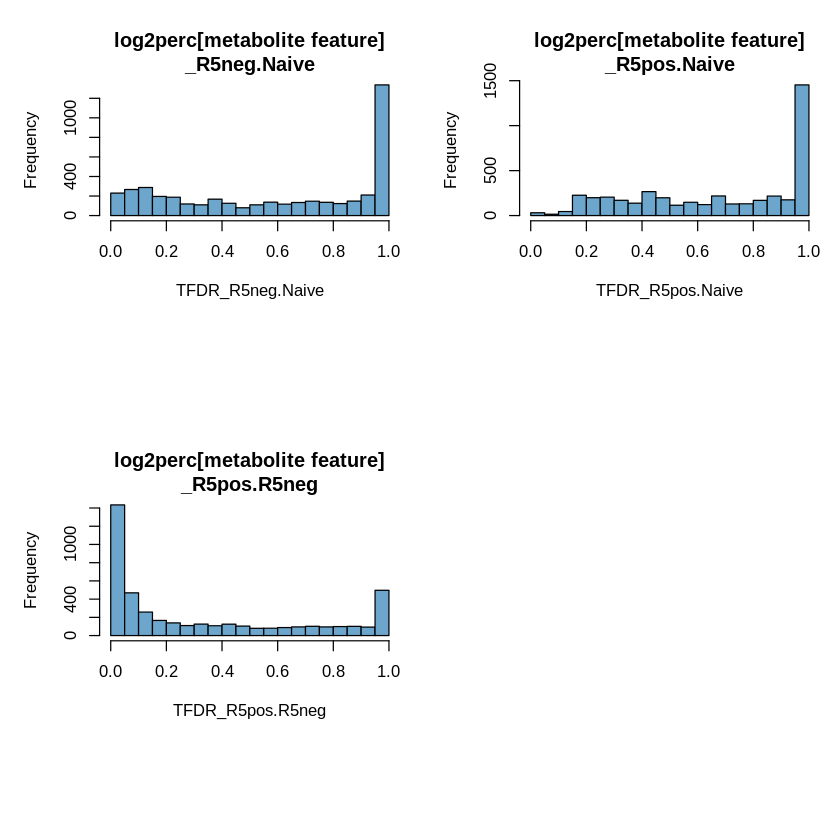

In [86]:
histogram_p(aov_tuk_df,'TFDR','\nlog2perc[metabolite feature]')

[1] "pval"


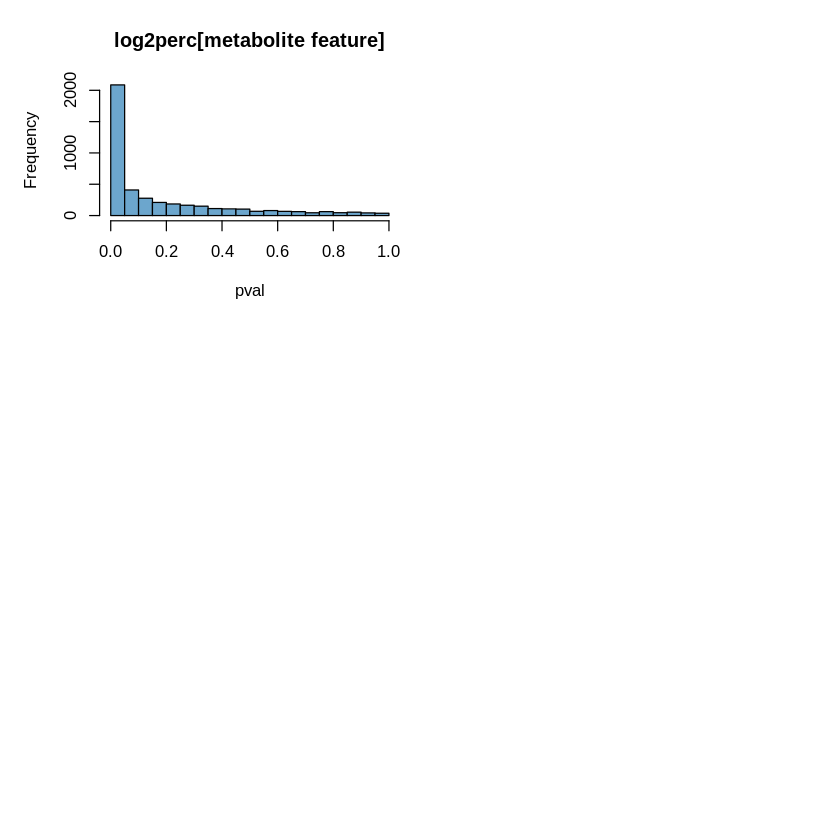

In [77]:
histogram_p(aov_tuk_df,'pval','\nlog2perc[metabolite feature]')

In [87]:
colnames(aov_tuk_df)

[1] "f_score"           "pval"              "padj"             
[4] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"
[7] "TFDR_R5neg.Naive"  "TFDR_R5pos.Naive"  "TFDR_R5pos.R5neg"

In [88]:
sign_df = aov_tuk_df[(aov_tuk_df$padj < 0.05),]
sign_df[1:10,]

,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,TFDR_R5neg.Naive,TFDR_R5pos.Naive,TFDR_R5pos.R5neg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,8.893732,1.604757e-02,0.0477060464,2.525009e-01,0.11346999,1.340772e-02,0.569658669,0.4245410,0.043642705
F10000,164.842150,5.710323e-06,0.0005958801,2.179699e-05,0.03849116,5.862164e-06,0.002442381,0.2762009,0.000826376
F10006,11.595463,8.683807e-03,0.0315446686,8.145709e-01,0.02037338,1.032288e-02,1.000000000,0.2176814,0.036409179
F10010,10.424715,1.115960e-02,0.0371126393,1.464763e-01,0.12384900,9.111863e-03,0.406155835,0.4390183,0.033206799
F10015,31.990585,6.302461e-04,0.0067997139,9.585662e-03,0.03118843,5.071496e-04,0.091869407,0.2532622,0.005957645
F10016,10.860398,1.013997e-02,0.0348636243,8.851236e-01,0.02151777,1.268558e-02,1.000000000,0.2238873,0.041965169
F10027,16.812905,3.471517e-03,0.0182338100,1.417907e-01,0.02935560,2.905392e-03,0.396941405,0.2499255,0.016575148
F10036,16.329541,3.738515e-03,0.0188870641,4.491388e-02,0.09599040,3.034032e-03,0.200075101,0.4006476,0.017020177
F10037,23.856699,1.393817e-03,0.0106156776,2.099753e-02,0.04827846,1.120106e-03,0.130711129,0.2980192,0.009333336


In [89]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.05,])[1]

[1] 1502

In [90]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.1,])[1]

[1] 2053

In [91]:
dim(aov_tuk_df[aov_tuk_df$pval < 0.05,])[1] # check raw p value

[1] 2086

-------

----

# construct the final result tables

In [92]:
detect_boundary_index = function(feat_df = feat_df,
                                 Data_RegExpr = '\\_[0-9]+'
                                ) {
    # the output index is the last index for the metainfo
    first_index4data = grep(Data_RegExpr,colnames(feat_df))[1]
    # range = colnames(feat_df)[first_index4data - 1:first_index4data + 1]
    print(colnames(feat_df)[first_index4data-1])
    return(first_index4data-1)
}

In [93]:
wrap_res2ful <- function(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index) {
    metainfo_df = feat_df[,1:end_index]
    metainfo_df = merge_by_rowName(metainfo_df,aov_tuk_df) # use merge by rowname in utilis
    m_df = merge_by_rowName(metainfo_df,
                 feat_df[(end_index + 1):ncol(feat_df)]) # use merge by rowname in utilis
    return(m_df)
}
    

In [94]:
metainfo_end_index = detect_boundary_index(feat_df = feat_df, 
                                           Data_RegExpr = '\\_[0-9]+')
full_res_df <- wrap_res2ful(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index)

[1] "log2FC_R5posvsR5neg"


In [95]:
dim(full_res_df)

[1] 4370   43

In [96]:
colnames(full_res_df)

[1] "mz"                  "rtime"               "rtime_left_base"    
 [4] "rtime_right_base"    "parent_masstrack_id" "peak_area"          
 [7] "cSelectivity"        "goodness_fitting"    "snr"                
[10] "detection_counts"    "Naive_percNA"        "Naive_mean"         
[13] "R5neg_percNA"        "R5neg_mean"          "R5pos_percNA"       
[16] "R5pos_mean"          "gMean_Naive"         "gMean_R5neg"        
[19] "gMean_R5pos"         "log2FC_R5negvsNaive" "log2FC_R5posvsNaive"
[22] "log2FC_R5posvsR5neg" "f_score"             "pval"               
[25] "padj"                "Tpadj_R5neg.Naive"   "Tpadj_R5pos.Naive"  
[28] "Tpadj_R5pos.R5neg"   "TFDR_R5neg.Naive"    "TFDR_R5pos.Naive"   
[31] "TFDR_R5pos.R5neg"    "Naive_1"             "Naive_2"            
[34] "Naive_3"             "R5neg_1"             "R5neg_2"            
[37] "R5neg_3"             "R5pos_1"             "R5pos_2"            
[40] "R5pos_3"             "nist"                "q3June2014_1"       
[43] "q3June2014_2"

## output

In [97]:
output_fdr = glue('../../output/{exp_label}_1wayANOVA/')
dir.create(output_fdr)

Warning message in dir.create(output_fdr):
“'../../output/hMinImp_TICnorm_groupFil0.3_HILICpos_1wayANOVA' already exists”


In [98]:
write.csv(full_res_df,
          file.path(output_fdr, 
                    glue('one_wayANOVA_{exp_label}_fullreport.csv')))

------

In [99]:
col_stat_score = colnames(feat_df)[grep('log2FC',colnames(feat_df))]

In [100]:
col_stat_score

[1] "log2FC_R5negvsNaive" "log2FC_R5posvsNaive" "log2FC_R5posvsR5neg"

In [101]:
col_padj_stat = colnames(aov_tuk_df)[grep('Tpadj',colnames(aov_tuk_df))]

In [102]:
col_padj_stat

[1] "Tpadj_R5neg.Naive" "Tpadj_R5pos.Naive" "Tpadj_R5pos.R5neg"

In [103]:
grepl('R5neg(\\.|vs)Naive',col_padj_stat)

[1]  TRUE FALSE FALSE

In [114]:
contrast_regExprs = c('R5neg(\\.|vs)Naive',
                      'R5pos(\\.|vs)Naive',
                      'R5pos(\\.|vs)R5neg')

res2mcg_tukey <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # Use log2FC as stat and padj/TFDR from tukey test for p cutoff
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2]
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [107]:
res2mcg_tukey(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

## 2-steps to control tukey stat


In [112]:
res2mcg_tukey_2steps <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # With 2 steps, the data go after Tpadj, 
    # but turn to 1 if the feature didn't pass the 1-way ANOVA FDR
    # Use log2FC as stat and padj from tukey test for p cutoff
    
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2] # just quick way to get the contrast
        
        mcg_df[glue("org_{padj_col}")] = mcg_df[padj_col]
        mcg_df[mcg_df$padj > 0.05, padj_col] = 1
        
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_2steps_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [113]:
res2mcg_tukey_2steps(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

------

## Summary: normal one-way ANOVA
- with Tukey post-hoc test
- Run through all the contrast